In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
#import cv2

w, h = 224, 224

content_base_path = "C:\\Users\\Patrick\\Desktop\\Anaconda Files\\Style Transfer\\Content images\\"
style_base_path = "C:\\Users\\Patrick\\Desktop\\Anaconda Files\\Style Transfer\\Style images\\"

file_type = ".jpg"
content_name = "huangshan mountains clear"
style_name = "winter sunset"
content_path = content_base_path + content_name + file_type
style_path = style_base_path + style_name + file_type

In [2]:
# Image manipulation utility functions
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

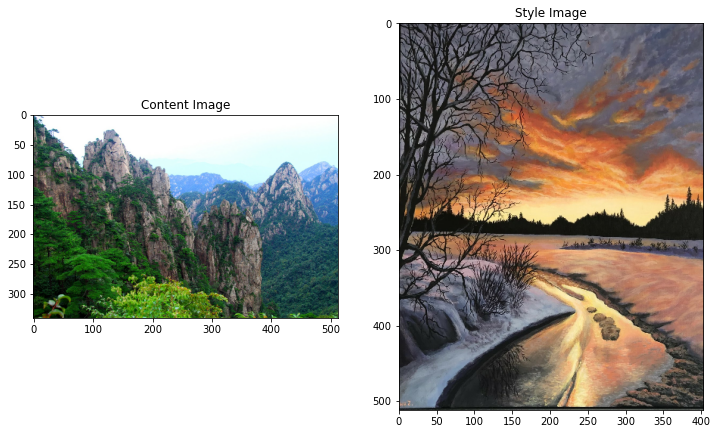

In [3]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [4]:
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

ModuleNotFoundError: No module named 'tensorflow_hub'

In [5]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (h, w))
mobile = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [6]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [7]:
def mobile_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  mobile = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  mobile.trainable = False

  outputs = [mobile.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([mobile.input], outputs)
  return model

In [8]:
style_extractor = mobile_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [12]:
style_outputs

[<tf.Tensor: shape=(1, 512, 403, 64), dtype=float32, numpy=
 array([[[[0.00000000e+00, 5.28812647e+00, 8.32097340e+00, ...,
           0.00000000e+00, 1.82737370e+01, 1.87747078e+01],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [0.00000000e+00, 1.32015886e+01, 7.85997915e+00, ...,
           0.00000000e+00, 3.37538033e+01, 0.00000000e+00],
          ...,
          [0.00000000e+00, 3.80384521e+01, 7.52778473e+01, ...,
           0.00000000e+00, 2.22327164e+02, 1.82354935e+02],
          [0.00000000e+00, 3.01649761e+01, 6.15037155e+01, ...,
           0.00000000e+00, 1.85060745e+02, 1.45470123e+02],
          [5.21133471e+00, 4.06628456e+01, 9.12587891e+01, ...,
           0.00000000e+00, 2.62908661e+02, 2.60990295e+02]],
 
         [[6.93314791e+00, 6.28974056e+00, 7.39821434e+00, ...,
           0.00000000e+00, 4.34885788e+00, 1.06184673e+01],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e

In [9]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [19]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.mobile = mobile_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.mobile.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.mobile(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [20]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

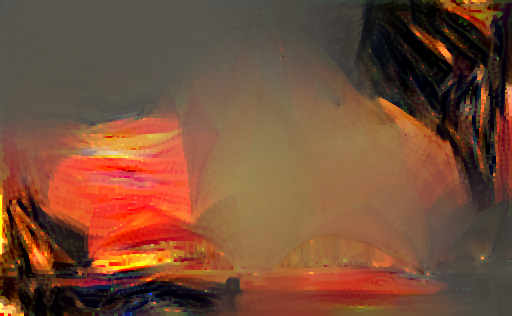

Train step: 2500
Total time: 541.6


In [110]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

ratio = 1e-2 # Equal to alpha/beta (content/style) in paper
content_weight = 100
style_weight = content_weight / ratio
total_variation_weight = 50

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    #loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

import time
start = time.time()

epochs = 25
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [276]:
file_name =  content_name + "-" + style_name + file_type
tensor_to_image(stylized_image).save(file_name)

In [277]:
# Testing upsampling
#upsampled_file_name = file_name[:(len(file_name)-len(file_type))] + '_upsampled' + file_type

#upsampled_image = cv2.pyrUp(cv2.imread(file_name))
#cv2.imwrite(upsampled_file_name, upsampled_image)

True